In [2]:
import folium
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import widgets, interactive
import plotly.graph_objs as go

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv('2019_nCoV_data.csv')

df.head()

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020 12:00:00,Anhui,China,01/22/2020 12:00:00,1.0,0.0,0.0
1,2,01/22/2020 12:00:00,Beijing,China,01/22/2020 12:00:00,14.0,0.0,0.0
2,3,01/22/2020 12:00:00,Chongqing,China,01/22/2020 12:00:00,6.0,0.0,0.0
3,4,01/22/2020 12:00:00,Fujian,China,01/22/2020 12:00:00,1.0,0.0,0.0
4,5,01/22/2020 12:00:00,Gansu,China,01/22/2020 12:00:00,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 8 columns):
Sno               1199 non-null int64
Date              1199 non-null object
Province/State    888 non-null object
Country           1199 non-null object
Last Update       1199 non-null object
Confirmed         1199 non-null float64
Deaths            1199 non-null float64
Recovered         1199 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 75.1+ KB


In [6]:
#Drop the 1st and 5th column
df.drop("Sno", axis=1, inplace=True)
df.drop("Last Update", axis=1, inplace=True)

In [7]:
#Rename 'Mainland China' to 'China'
df.replace('Mainland China', 'China', inplace=True)

In [8]:
#Transform date to date type
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.head()

,Date,Province/State,Country,Confirmed,Deaths,Recovered
0,2020-01-22 12:00:00,Anhui,China,1.0,0.0,0.0
1,2020-01-22 12:00:00,Beijing,China,14.0,0.0,0.0
2,2020-01-22 12:00:00,Chongqing,China,6.0,0.0,0.0
3,2020-01-22 12:00:00,Fujian,China,1.0,0.0,0.0
4,2020-01-22 12:00:00,Gansu,China,0.0,0.0,0.0


In [10]:
df = df.groupby(by=['Date', 'Country']).agg({'Confirmed': 'sum',
                                                'Deaths': 'sum',
                                                'Recovered': 'sum'}).unstack().reset_index().fillna(0)

In [11]:
df

Date Confirmed                                          \
Country                     Australia Belgium Brazil Cambodia Canada    China   
0       2020-01-22 12:00:00       0.0     0.0    0.0      0.0    0.0    549.0   
1       2020-01-23 12:00:00       0.0     0.0    0.0      0.0    0.0    639.0   
2       2020-01-24 12:00:00       0.0     0.0    0.0      0.0    0.0    916.0   
3       2020-01-25 22:00:00       4.0     0.0    0.0      0.0    0.0   1979.0   
4       2020-01-26 23:00:00       4.0     0.0    0.0      0.0    1.0   2737.0   
5       2020-01-27 20:30:00       5.0     0.0    0.0      1.0    1.0   4409.0   
6       2020-01-28 23:00:00       5.0     0.0    0.0      1.0    2.0   5970.0   
7       2020-01-29 21:00:00       7.0     0.0    0.0      1.0    3.0   7678.0   
8       2020-01-30 21:30:00       9.0     0.0    0.0      1.0    3.0   9658.0   
9       2020-01-31 19:00:00       9.0     0.0    0.0      1.0    3.0  11221.0   
10      2020-02-01 23:00:00      12.0     0.0    0.0      1.0    4.0  14375.0   
11      2020-02-02 21:00:00      12.0     0.0    0.0      1.0    4.0  17114.0   
12      2020-02-03 21:40:00      12.0     0.0    0.0      1.0    4.0  20400.0   
13      2020-02-04 22:00:00      13.0     1.0    0.0      1.0    4.0  24290.0   
14      2020-02-05 12:20:00      13.0     1.0    0.0      1.0    4.0  24405.0   
15      2020-02-06 20:05:00      14.0     1.0    0.0      1.0    5.0  30541.0   
16      2020-02-07 20:24:00      15.0     1.0    0.0      1.0    7.0  31215.0   
17      2020-02-08 23:04:00      15.0     1.0    0.0      1.0    7.0  37198.0   
18      2020-02-09 23:20:00      15.0     1.0    0.0      1.0    7.0  40160.0   
19      2020-02-10 19:30:00      15.0     1.0    0.0      1.0    7.0  42310.0   

                                ...   Recovered                                \
Country Finland France Germany  ... South Korea Spain Sri Lanka Sweden Taiwan   
0           0.0    0.0     0.0  ...         0.0   0.0       0.0    0.0    0.0   
1           0.0    0.0     0.0  ...         0.0   0.0       0.0    0.0    0.0   
2           0.0    2.0     0.0  ...         0.0   0.0       0.0    0.0    0.0   
3           0.0    3.0     0.0  ...         0.0   0.0       0.0    0.0    0.0   
4           0.0    3.0     0.0  ...         0.0   0.0       0.0    0.0    0.0   
5           0.0    3.0     1.0  ...         0.0   0.0       0.0    0.0    0.0   
6           0.0    4.0     4.0  ...         0.0   0.0       0.0    0.0    0.0   
7           1.0    5.0     4.0  ...         0.0   0.0       0.0    0.0    0.0   
8           1.0    5.0     4.0  ...         0.0   0.0       0.0    0.0    0.0   
9           1.0    6.0     7.0  ...         0.0   0.0       0.0    0.0    0.0   
10          1.0    6.0     8.0  ...         0.0   0.0       0.0    0.0    0.0   
11          1.0    6.0    10.0  ...         0.0   0.0       0.0    0.0    0.0   
12          1.0    6.0    12.0  ...         0.0   0.0       0.0    0.0    0.0   
13          1.0    6.0    12.0  ...         0.0   0.0       0.0    0.0    0.0   
14          1.0    6.0    12.0  ...         0.0   0.0       0.0    0.0    0.0   
15          1.0    6.0    12.0  ...         0.0   0.0       0.0    0.0    1.0   
16          1.0    6.0    13.0  ...         1.0   0.0       0.0    0.0    1.0   
17          1.0   11.0    13.0  ...         3.0   0.0       1.0    0.0    1.0   
18          1.0   11.0    14.0  ...         3.0   0.0       1.0    0.0    1.0   
19          1.0   11.0    14.0  ...         3.0   0.0       1.0    0.0    1.0   

                                                         
Country Thailand   UK   US United Arab Emirates Vietnam  
0            0.0  0.0  0.0                  0.0     0.0  
1            0.0  0.0  0.0                  0.0     0.0  
2            0.0  0.0  0.0                  0.0     0.0  
3            0.0  0.0  0.0                  0.0     0.0  
4            2.0  0.0  0.0                  0.0     0.0  
5            2.0  0.0  0.0                  0.0    

In [12]:


# Make a dropdown to select country, or "All"
country = widgets.Dropdown(
    options=['All'] + list(df['Confirmed']),
    #options=list(df['Confirmed']),
    value='All',
    description='Country:',
)





def corona_plot(country):
    
    fig, ax = plt.subplots(figsize=(10, 10))
                            
    t = df["Date"]
    
    if (country == 'All'):
        confirmed = df['Confirmed'].sum(axis=1)
        recovered_and_deaths = df['Recovered'].sum(axis=1)+df['Deaths'].sum(axis=1)
        deaths = df['Deaths'].sum(axis=1)
    else:
        confirmed = df[('Confirmed', country)]
        recovered_and_deaths = df[('Recovered', country)]+df[('Deaths', country)]
        deaths = df[('Deaths', country)]

    
        
    ax.fill_between(t, recovered_and_deaths, confirmed, color='orange')
    ax.fill_between(t, recovered_and_deaths, deaths, color='green')
    ax.fill_between(t, deaths, 0, color='red')

    numberOfDates = 6
    dayIntervalNumber = int(len(df) / numberOfDates)

    days = mdates.DayLocator()  # every month
    dayInterval = mdates.DayLocator(interval=dayIntervalNumber)  # every n days
    
    dayFmt = mdates.DateFormatter('%b %d')
    ax.xaxis.set_major_locator(dayInterval)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(dayFmt)


    fig.autofmt_xdate()

    plt.ylabel('Number of people',fontsize=12)
    plt.xlabel('Date',fontsize=12)
    
    if (country == 'All'):
        plt.title('Total cases in the world',fontsize=15)
    else:
        plt.title('Number of cases in ' + country,fontsize=15)
        
    plt.legend(["Infected", 'Recovered', 'Deaths'], loc = 'upper left')
    



interactive(corona_plot, country=country)

interactive(children=(Dropdown(description='Country:', options=('All', 'Australia', 'Belgium', 'Brazil', 'Camb…

In [13]:
df2 = df['Confirmed'].tail(1).transpose()
df3 = df2.loc[(df2!=0).any(1)]
#df2 = df['Confirmed'].tail(1).transpose().iloc[:,0]

In [14]:
df3
#df3 = df2[df2.columns[0]]
#type(df3)

,19
Country,
Australia,15.0
Belgium,1.0
Cambodia,1.0
Canada,7.0
China,42310.0
Finland,1.0
France,11.0
Germany,14.0
Hong Kong,38.0


In [15]:
df3.index[0]
#df2[df2.columns[0]]

'Australia'

In [16]:
sortedL = df3.iloc[:,0].sort_values()

In [17]:
sortedL.tail(3)[0]

45.0

In [18]:

world_map = px.choropleth(df3, 
                    locations=df3.index, 
                    locationmode = "country names", 
                    hover_name=df3.index, 
                    color=df3,
                    color_continuous_scale=px.colors.sequential.Oranges,
                    range_color=[0,sortedL.tail(3)[0]])





def hover_fn(trace, points, state):
    
    ind = points.point_inds[0]
    country = df3.index[ind]
    country_menu.value = country

    
fig_map  = go.FigureWidget(world_map)

for f in fig_map.data:
    f.on_hover(hover_fn)

    
    
country_menu = widgets.Dropdown(
    options=['All'] + list(df3.index),
    #options=list(df['Confirmed']),
    value='All',
    description='Country:'
)


display(fig_map, interactive(corona_plot, country=country_menu))



#fig_map


FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hoverlabel':…

interactive(children=(Dropdown(description='Country:', options=('All', 'Australia', 'Belgium', 'Cambodia', 'Ca…

# <h1><center>Centered text!</center></h1>

In [101]:
dff = px.data.gapminder()
fig2 = px.choropleth(dff, locations="country", locationmode = "country names", color="lifeExp", range_color=[0,80])
#fig2 = px.choropleth(dff, locations="country", locationmode = "country names", color="lifeExp", hover_name="country", animation_frame="year", range_color=[0,80])
fig2.show()


In [56]:
dff

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


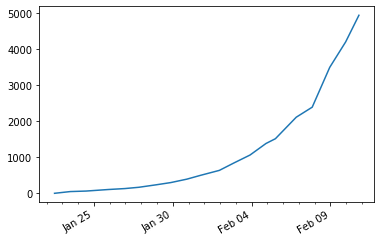

In [37]:

monthFmt = mdates.DateFormatter('%b %d')
dayFmt = mdates.DateFormatter('%d')


#ax.xaxis.set_major_locator(mdates.YearLocator())
fig, ax = plt.subplots()
ax.plot(df["Date"], df[('Recovered', 'China')]+df[('Deaths', 'China')])

numberOfDates = 4
dayIntervalNumber = int(len(df) / numberOfDates)

days = mdates.DayLocator()  # every month
dayInterval = mdates.DayLocator(interval=dayIntervalNumber)  # every n days


ax.xaxis.set_major_locator(dayInterval)
ax.xaxis.set_minor_locator(days)

ax.xaxis.set_major_formatter(monthFmt)

#ax.tick_params(direction='out', pad=15)

fig.autofmt_xdate()

In [536]:
country_data.drop(country_data.columns.difference([('Date', ''), ('Recovered', 'China')]), axis=1)

,Date,Recovered
Country,,China
0,2020-01-22,0.0
1,2020-01-23,30.0
2,2020-01-24,36.0
3,2020-01-25,49.0
4,2020-01-26,51.0
5,2020-01-27,60.0
6,2020-01-28,104.0
7,2020-01-29,127.0
8,2020-01-30,179.0


In [537]:
country_data.drop(country_data.columns.difference([('Date', ''), ('Deaths', 'China')]), axis=1)

,Date,Deaths
Country,,China
0,2020-01-22,0.0
1,2020-01-23,18.0
2,2020-01-24,26.0
3,2020-01-25,56.0
4,2020-01-26,80.0
5,2020-01-27,107.0
6,2020-01-28,132.0
7,2020-01-29,170.0
8,2020-01-30,213.0


<Figure size 14400x7200 with 0 Axes>

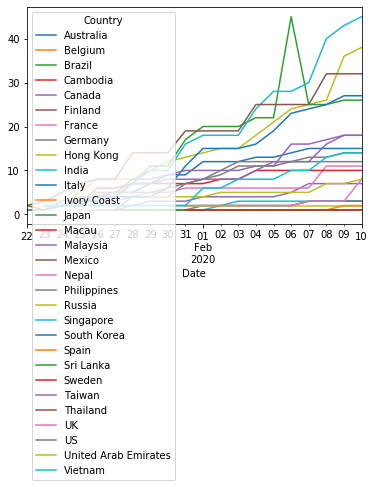

In [242]:
import matplotlib.pyplot as plt
plt.figure(figsize=(200,100))
country_data.drop([('Confirmed', 'China'), ('Confirmed', 'Others')], axis=1).plot(x='Date', y='Confirmed')

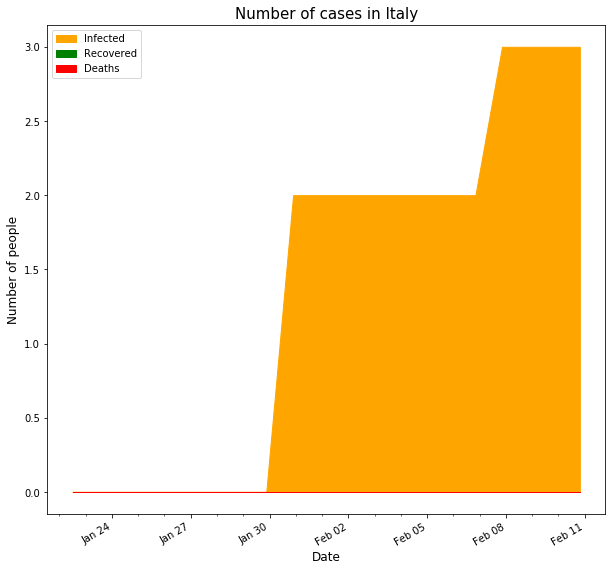

In [11]:
country = 'Italy'



monthFmt = mdates.DateFormatter('%b %d')
dayFmt = mdates.DateFormatter('%d')

t = df["Date"]
confirmed = df[('Confirmed', country)]
recovered_and_deaths = df[('Recovered', country)]+df[('Deaths', country)]
deaths = df[('Deaths', country)]

#ax.xaxis.set_major_locator(mdates.YearLocator())
fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(t, confirmed, color='orange')
#ax.plot(t, recovered_and_deaths, color='green')
#ax.plot(t, deaths, color='red')

#ax.plot(t, df[('Confirmed', country)], color='red')

ax.fill_between(t, recovered_and_deaths, confirmed, color='orange')
ax.fill_between(t, recovered_and_deaths, deaths, color='green')
ax.fill_between(t, deaths, 0, color='red')

numberOfDates = 6
dayIntervalNumber = int(len(df) / numberOfDates)

days = mdates.DayLocator()  # every month
dayInterval = mdates.DayLocator(interval=dayIntervalNumber)  # every n days


ax.xaxis.set_major_locator(dayInterval)
ax.xaxis.set_minor_locator(days)

ax.xaxis.set_major_formatter(monthFmt)

#ax.tick_params(direction='out', pad=15)

fig.autofmt_xdate()

#ax = country_data.drop(country_data.columns.difference([('Date', ''), ('Confirmed', country)]), axis=1).plot(x='Date', color='orange')
#country_data.drop(country_data.columns.difference([('Date', ''), ('Recovered', country)+('Deaths', country)]), axis=1).plot(x='Date', y='Recovered', ax=ax, color='green')
#country_data.drop(country_data.columns.difference([('Date', ''), ('Deaths', country)]), axis=1).plot(x='Date', y='Deaths', ax=ax, color='red')
plt.ylabel('Number of people',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.title('Number of cases in ' + country,fontsize=15)
plt.legend(["Infected", 'Recovered', 'Deaths'], loc = 'upper left')